In [1]:
# set the matplotlib backend so figures can be saved in the background
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import matplotlib
import keras
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2

import shutil
import fnmatch
import pickle
from keras import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Input
from keras.constraints import max_norm
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
import keras.initializers
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import keras.optimizers
from keras.utils import np_utils
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import imgaug as ia
from imgaug import augmenters as iaa

TRAIN_DIR = '../TRAIN' 

/home/as12production/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def buildImageDataset(path, imageResize=None,shuffle=False,seed=0):
    """
    Load dataset into an array. Labels are defined by folder name.
    """
    filenames = []
    data = []
    labels = []
    imagePaths = sorted(list(paths.list_images(path)))
    
    if shuffle == True:
        random.seed(seed)
        random.shuffle(imagePaths)
    
    for imagePath in imagePaths:
        if "-40-" not in imagePath:
            continue
        #print(imagePath)
        image = cv2.imread(imagePath)
        
        if imageResize != None:
            image = cv2.resize(image, imageResize)
        image = img_to_array(image)
        data.append(image)
        filenames.append(imagePath)
        label = imagePath.split(os.path.sep)[-2]
        labels.append(CLASS_LABELS.index(label))
    return (np.array(data), np.array(labels), np.array(filenames))

def showClassDistribution(y, labels):
    figure = plt.figure(figsize=(10,5))
    ax = sns.countplot(x = y)
    ax.set_xticklabels(labels)
    plt.show()

def imageResizer(dataset, imageResize):
    result = []
    for image in dataset:
        result.append(ia.imresize_single_image(image, imageResize))
    return np.array(result)

In [8]:
#split images into regions

def splitImage(image, n_split, resize):
    """
    Takes a numpy image matrix, and split them based into nxn matrix
    return numpy matrix (regions, rows, columns, channel)
    """
    import numpy as np
    from scipy.misc import imresize 
    #Calculate region width and height
    block_r = int(np.floor(image.shape[0] / n_split))
    block_c = int(np.floor(image.shape[1] / n_split))
    
    result = []
    #Split the image based on block_r and block_c, and append it to result array
    row = 0
    for _ in range(0,n_split-1):
        col = 0
        start_r = row  * block_r
        for _ in range(0,n_split-1):
            start_c = col  * block_c
            result.append(imresize(image[start_r:start_r + block_r, start_c:start_c + block_c,:],resize))
            col += 1
        #Some images may not divide evenly, so use the remaining pixels on the last patch
        start_c = col * block_c
        result.append(imresize(image[start_r:start_r + block_r, start_c:,:],resize))
        row += 1
    #Some images may not divide evenly, so use the remaining pixels on the last patch
    start_r = row  * block_r
    col = 0
    for _ in range(0,n_split-1):
        start_c = col  * block_c
        result.append(imresize(image[start_r:, start_c:start_c + block_c,:],resize))
        col += 1
    #Some images may not divide evenly, so use the remaining pixels on the last patch
    start_c = col * block_c
    result.append(imresize(image[start_r:, start_c:, :],resize))
    return np.array(result).astype('float')/255.0


def regionScore(image, threshold=(0.5,0.5,0.5)):
    """
    Takes a numpy image matrix (row,col,channels) and associated threshold value for each channels.
    Return a copy of matrix with anything greater than or equal to threshold sets to 
    """
    import numpy as np
    
    def color_threshold(img, th):
        """
        Takes a numpy image matrix (row,col,channels) and associated threshold value for each channel. 
        Return a copy of matrix with anything greater than or equal to threshold sets to one and zero for everything else.
        """
        assert img.shape[2] == len(th), "number of channels must be equal to number of threshold"
        result = np.copy(img)
        for channel, value in enumerate(th):
            low_values_flags = result[:,:,channel] < value  # Where values are low
            high_values_flags = result[:,:,channel] >= value  # Where values are low
            result[low_values_flags,channel] *= -1  # All low values set to 0
            result[high_values_flags,channel] = 0  # All low values set to 0
        return result
    return np.sum(color_threshold(image, threshold))

def segmentCell(set_of_images, resize , n_patch):
    cell = []
    for index, image in enumerate(set_of_images):
        score = []
        patches = []
        for patch in splitImage(image,n_patch,resize):
            score.append(regionScore(patch, threshold=(0.5,0.5,0.5)))
            patches.append(patch)
        # Non-Maximum suppression
        score = np.array(score)
        patches = np.array(patches)
        cell.append(patches[np.argmax(score)])
    return np.array(cell)

In [3]:
def isRegionOfInterest(image, threshold=(0.5,0.5,0.5), perecent_threshold=0.25):
    """
    Takes a numpy image matrix (row,col,channels) and associated threshold value for each channels.
    Return a copy of matrix with anything greater than or equal to threshold sets to 
    """
    import numpy as np
    
    def color_threshold(img, th):
        """
        Takes a numpy image matrix (row,col,channels) and associated threshold value for each channel. 
        Return a copy of matrix with anything greater than or equal to threshold sets to one and zero for everything else.
        """
        assert img.shape[2] == len(th), "number of channels must be equal to number of threshold"
        result = np.copy(img)
        for channel, value in enumerate(th):
            low_values_flags = result[:,:,channel] < value  # Where values are low
            high_values_flags = result[:,:,channel] >= value  # Where values are low
            result[low_values_flags,channel] *= -1  # All low values set to 0
            result[high_values_flags,channel] = 0  # All low values set to 0
        return result

    def totalImageSize(patch):
        """
        Takes a numpy image matrix (row, col, channels) and return the total number of elements
        """
        size = 1
        for i in patch.shape:
            size *= i
        return size
    
    if ( float(np.sum(color_threshold(image, threshold))) / totalImageSize(image)) > float(perecent_threshold):
        return True
    else:
        return False
    

In [4]:
path =  '../TEST'
CLASS_LABELS = ["Benign", "Malignant"]
set_of_images,_,_ = buildImageDataset(path, imageResize=None,shuffle=False,seed=0)
print(set_of_images.shape)

(232, 460, 700, 3)


In [24]:
a = np.array([1,2,1,2])
np.argmax(a)

1

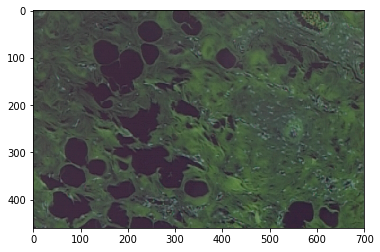

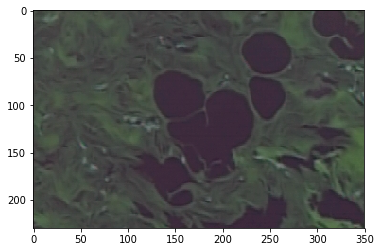

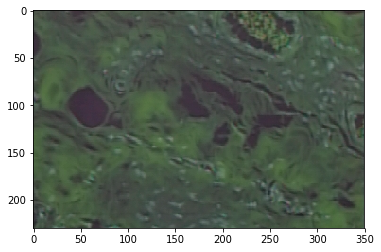

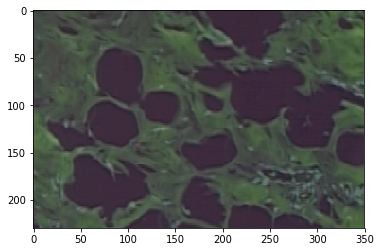

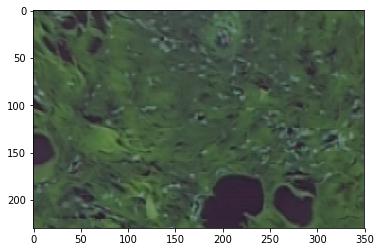

In [8]:
# Hyper-parameter

#set_of_images /= 255.0

early_stop = 1

for index, image in enumerate(set_of_images):
    if index >= early_stop:
        break
    plt.imshow(image)
    plt.show()
    for patch in splitImage(image,2):
        plt.imshow(patch)
        plt.show()

In [5]:
set_of_images /= 255

In [13]:
early_stop = 5000
cell = []
not_cell = []


cell = segmentCell(set_of_images, (224,224), 16)
#for index, image in enumerate(set_of_images):
    #if index >= early_stop:
      #  break
    #for patch in splitImage(image,2):
        
     #   if (segmentCell(patch, threshold=(0.4,0.4,0.4), perecent_threshold=0.01)):
      #      cell.append(patch)
       # else:
        #    not_cell.append(patch)


cell = np.array(cell)
not_cell = np.array(not_cell)

/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


MemoryError: 

In [ ]:
print(set_of_images.shape)
print(cell.shape)
print(not_cell.shape)

In [ ]:
!rm cell/*
!rm not_cell/*

In [ ]:
import scipy.misc

max_write = 10


for i,img in enumerate(cell): 
    if i > max_write:
        break
    scipy.misc.imsave('cell/'+str(i)+'.jpg', img)

for i,img in enumerate(not_cell): 
    if i > max_write:
        break
    scipy.misc.imsave('not_cell/'+str(i)+'.jpg', img)